## Exercise 5.8: Racetrack (programming) 
Consider driving a race car around a turn like those shown in Figure 5.5. You want to go as fast as possible, but not so fast as to run off the track. In our simplified racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram. 
* The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. 
* The actions are increments to the velocity components. Each may be changed by +1, −1, or 0 in one step, for a total of nine actions. 
* Both velocity components are restricted to be nonnegative and less than 5, and they cannot both be zero except at the starting line. 
* Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line. 
* The rewards are −1 for each step until the car crosses the finish line. 
* If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues. 
* Before updating the car’s location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line. 
* To make the task more challenging, with probability 0.1 at each time step the velocity increments are both zero, independently of the intended increments. 

Apply a Monte Carlo control method to this task to compute the optimal policy from each starting state. Exhibit several trajectories following the optimal policy (but turn the noise off for these trajectories).

<img src="racetrack.png" width="600">

In [59]:
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os

CELL_TYPE_WALL = 0
CELL_TYPE_TRACK = 1
CELL_TYPE_GOAL = 2
CELL_TYPE_START = 3

class RaceTrack:
    def __init__(self, track, min_vel=0, max_vel=5):
        self.track = track
        self.wall_cells = np.argwhere(track == CELL_TYPE_WALL).tolist()
        self.goal_cells = np.argwhere(track == CELL_TYPE_GOAL).tolist()
        self.start_cells = np.argwhere(track == CELL_TYPE_START).tolist()
        self.min_vel = min_vel
        self.max_vel = max_vel
    
    @classmethod
    def from_csv(cls, file_path):
        
        file_path = os.path.join(os.getcwd(), file_path)
        
        track = genfromtxt(file_path, delimiter=',')
        
        # Flip the y-axis coordinates
        track = np.flip(track, axis=0)

        return cls(track) 
    
    def possible_actions(self, state):
        actions = [[a_y, a_x] for a_y in range(-1, 2) for a_x in range(-1, 2)]
        legal_actions = []

        _, _, v_y, v_x = state

        # Discard illegal actions
        for a in actions:
            a_y, a_x = a
            # Cannot go above speed limit in any x direction
            if v_x + a_x < self.min_vel or v_x + a_x > self.max_vel:
                continue
            # Cannot go above speed limit in any y direction
            if v_y + a_y < self.min_vel or v_y + a_y > self.max_vel:
                continue
            # Cannot noop
            if v_x + a_x == 0 and v_y + a_y == 0:
                continue
            legal_actions.append(a)
        return legal_actions
    
    def random_start_state(self):
        start_cell_idx = np.random.choice(len(self.start_cells))
        start_state = np.array(self.start_cells[start_cell_idx] + [0, 0])
        return start_state
    
    def apply_action(self, state, action):
        y_coord, x_coord, y_vel, x_vel = state
        a_y, a_x = action

        next_y_vel = y_vel + a_y
        next_x_vel = x_vel + a_x
        next_y_coord = y_coord + next_y_vel
        next_x_coord = x_coord + next_x_vel

        path = self.projected_path(
            (y_coord, x_coord), (next_y_vel, next_x_vel))

        if self.crossed_finish_line(path):
        #if self.crossed_finish_line([[next_y_coord, next_x_coord]]):
            return np.array([next_y_coord, next_x_coord, next_y_vel, next_x_vel]), 0, True
        #if self.crossed_track_boundary(path):
        if self.crossed_track_boundary([[next_y_coord, next_x_coord]]):
            return self.random_start_state(), -1, False

        return np.array([next_y_coord, next_x_coord, next_y_vel, next_x_vel]), -1, False
        
    def projected_path(self, state, speed):
        # TODO: Should we only consider end state directly?
        y_coord, x_coord = state
        y_vel, x_vel = speed

        new_y_coord = y_coord + y_vel
        new_x_coord = x_coord + x_vel

        path = []
        for dy in range(min(y_coord, new_y_coord), max(y_coord, new_y_coord) + 1):
            for dx in range(min(x_coord, new_x_coord), max(x_coord, new_x_coord) + 1):
                path.append([dy, dx])
        return path
        
    def crossed_track_boundary(self, projected_path):
        for cell in projected_path:
            y, x = cell
            if y < 0 or y >= self.track.shape[0] or x < 0 or x >= self.track.shape[1] or cell in self.wall_cells:
                return True
        return False

    def crossed_finish_line(self, projected_path):
        for cell in projected_path:
            if cell in self.goal_cells:
                return True
        return False
        
    def draw_episode(self, S, A, R): 
        colors = ['black', 'white', 'yellow', 'red']
        
        print(S)
        
        y_t = [s[1] for s in S]
        x_t = [s[0] for s in S]
        
        plt.figure(figsize=(10,10))
        plt.imshow(self.track, cmap=ListedColormap(colors), origin='lower',interpolation='none')
        
        def rect(pos, edgecolor='k', facecolor='none'):
            r = plt.Rectangle(pos, 1, 1, facecolor=facecolor,
                              edgecolor=edgecolor, linewidth=2)
            plt.gca().add_patch(r)

        for i in range(self.track.shape[0]):
            for j in range(self.track.shape[1]):
                rect((j-0.5, i-0.5))
        
        plt.plot(np.asarray(y_t), np.asarray(x_t),'o-')
        #plt.scatter(y_t[-1], x_t[-1], color='red', s=50)
        
#         fig=plt.figure(figsize=(10,10))
#         im = plt.imshow(self.track, cmap=ListedColormap(colors),
#                         origin='lower', interpolation='none')
        
#         def init():
#             im.set_data(self.track)
#             return [im]
            
#         def animate(i):
#             a = im.get_array()
            
        
        

        

#         

#         if path:
#             for cell in path:
#                 rect((cell[1]-0.5, cell[0]-0.5), edgecolor='g')

#         if car_cell:
#             rect((car_cell[1]-0.5, car_cell[0]-0.5),
#                  edgecolor='g', facecolor='g')

        plt.gca().invert_yaxis()
        #return im
        

In [60]:
rt = RaceTrack.from_csv("../racetracks/map1.csv")

In [61]:
path = rt.projected_path((6,8),(-2,2))
path

[[4, 8], [4, 9], [4, 10], [5, 8], [5, 9], [5, 10], [6, 8], [6, 9], [6, 10]]

In [62]:
import random
import math
from collections import defaultdict

class OnPolicyMonteCarloAgent:
    def __init__(self, track, gamma=0.25, n_episodes=100000, eps=0.9):
        self.track = track
        self.gamma = gamma
        self.n_episodes = n_episodes
        self.eps = eps

        # Initialize Q values and C values
        y_range = track.track.shape[0]
        x_range = track.track.shape[1]
        yvel_range = track.max_vel - track.min_vel + 1
        xvel_range = track.max_vel - track.min_vel + 1
        yacc_range = 3  # -1, 0, +1
        xacc_range = 3  # -1, 0, +1

        # Initialize state-action values
        self.Q = np.zeros((y_range, x_range, yvel_range,
                           xvel_range, yacc_range, xacc_range))

        # Initialize rewards dictionary
        self.R = defaultdict(list)

        # Initial Policy
        # For each state: assign equal probability of selecting each valid action from the state
        self.pi = np.zeros(self.Q.shape, dtype=float)
        for y_coord in range(self.Q.shape[0]):
            for x_coord in range(self.Q.shape[1]):
                for y_vel in range(track.min_vel, track.max_vel + 1):
                    for x_vel in range(track.min_vel, track.max_vel + 1):
                        valid_actions = self.track.possible_actions(
                            (y_coord, x_coord, y_vel, x_vel))
                        for y_acc, x_acc in valid_actions:
                            self.pi[y_coord, x_coord, y_vel, x_vel,
                                    y_acc, x_acc] = 1/len(valid_actions)
                        
    def sample_random_action(self, state):
        # Sample action according to our eps-greedy policy
        # Ensure that probabilities we sample from sum to 1
        y_coord, x_coord, y_vel, x_vel = state

        actionprobs = self.pi[y_coord, x_coord, y_vel, x_vel]
        total_prob = np.sum(actionprobs)
        if not math.isclose(total_prob, 1, abs_tol=0.01):
            print(
                'Action probabilities must sum to 1.0, but summed to {}, state: {}, actionprobs: {}'.format(total_prob, state, self.pi[tuple(state)]))
            sys.exit(1)

        linear_idx = np.random.choice(
            actionprobs.size, p=actionprobs.ravel())
        a = np.unravel_index(linear_idx, actionprobs.shape)
        # In case the value is greater than the max allowed action we need to translate it back into
        # negative coordinates
        a = tuple(acc if acc <= 1 else 1 - acc for acc in a)
        return a
    
    def greedy_action(self, state):
        # Find greedy action according to state-action values Q
        Q_state = self.Q[tuple(state)].copy()
        if not (Q_state == 0).all():
            Q_state[Q_state == 0] = np.nan
        a = np.unravel_index(np.nanargmax(Q_state, axis=None), Q_state.shape)
        # In case the value is greater than the max allowed action we need to translate it back into
        # negative coordinates
        a = tuple(acc if acc <= 1 else 1 - acc for acc in a)
        return a
            
    def generate_episode(self, policy):
        S = []
        A = []
        R = []

        # Select the initial state randomly
        start_state = self.track.random_start_state()
        S.append(start_state)

        terminated = False
        t = 0
        while not terminated:
            St = S[t]

            if t % 10000 == 0:
                print("Step: {}".format(t))
                
            a = policy(St)
            A.append(a)

            next_state, reward, terminated = self.track.apply_action(St, a)

            R.append(reward)
            S.append(next_state)
            t += 1

            # time.sleep(1)
        print("Terminated after {} steps".format(t))
        return S, A, R
    
    def policy_iteration(self):
        policy_stable = False
        it = 0
        while True:
            if self.n_episodes is not None and it > self.n_episodes:
                break
            elif self.n_episodes is None and policy_stable:
                break
            
            print('Iteration {}'.format(it))

            # (a) Generate an episode using pi
            S, A, R = self.generate_episode(self.sample_random_action)

            visited = set()

            # (b) Iterate over s,a pairs and update rewards and q-values
            old_Q = self.Q.copy()
            for t in range(len(S)-2):
                St, At, Rt = S[t], A[t], R[t]

                state_action_key = tuple(St.tolist() + list(At))

                # Skip to next step if we have aldready encountered this state, action pair
                if state_action_key in visited:
                    continue

                visited.add(state_action_key)

                # Calculate return that follows the first occurence of St, At
                G = 0
                for dt in range(len(S)-2, t-1, -1):
                    G = self.gamma * G + R[dt]

                self.R[state_action_key].append(G)
                self.Q[state_action_key] = np.average(self.R[state_action_key])

            # Q-diff: Credit to Joakim Blach Andersen
            Q_diff = abs(old_Q - self.Q)
            print('Q-diff: {}'.format(np.max(Q_diff)))

            # (c) Iterate over all states s and update the eps-greedy policy
            for t in range(len(S)-2):
                y, x, y_vel, x_vel = S[t]

                possible_actions = self.track.possible_actions(S[t])
                for a in possible_actions:
                    a_y, a_x = a

                    self.pi[y, x, y_vel, x_vel, a_y, a_x] = self.eps / \
                        len(possible_actions)

                # Get index of best action
                a_ys, a_xs = tuple(zip(*possible_actions))
                actionvals = self.Q[y, x, y_vel,
                                    x_vel, a_ys, a_xs]
                a_max_idx = np.argmax(actionvals)
                a_max_y, a_max_x = a_ys[a_max_idx], a_xs[a_max_idx]

                self.pi[y, x, y_vel, x_vel, a_max_y, a_max_x] += 1 - self.eps

                actionprobs = self.pi[y, x, y_vel, x_vel]
                total_prob = np.sum(actionprobs)
                if not math.isclose(total_prob, 1, abs_tol=0.01):
                    print(
                        'Action probabilities must sum to 1.0, but summed to {}, state: {}, actionprobs: {}'.format(total_prob, s, self.pi[y, x, y_vel, x_vel]))
                    sys.exit(1)
            
            # Check if convergence in case no number of episodes is set to 0
            if np.allclose(old_Q, self.Q, atol=0.05):
                print("Policy iteration converged after {} episodes".format(it))
                policy_stable = True

            # Counter and update epsilon
            self.eps = 1/(math.sqrt(it+1.1))
            it += 1

In [71]:
agent = OnPolicyMonteCarloAgent(rt, n_episodes=1000, eps=0.5, gamma=0.9)

In [72]:
agent.policy_iteration()

Iteration 0
Step: 0
Terminated after 1229 steps
Q-diff: 9.999999999999995
Iteration 1
Step: 0
Terminated after 504 steps
Q-diff: 9.999999999999995
Iteration 2
Step: 0
Terminated after 4524 steps
Q-diff: 9.999999999999995
Iteration 3
Step: 0
Terminated after 605 steps
Q-diff: 9.999999999999995
Iteration 4
Step: 0
Terminated after 1682 steps
Q-diff: 9.999999999999995
Iteration 5
Step: 0
Terminated after 1160 steps
Q-diff: 9.999999999999995
Iteration 6
Step: 0
Terminated after 984 steps
Q-diff: 9.999999999999995
Iteration 7
Step: 0
Terminated after 4386 steps
Q-diff: 9.999999999999995
Iteration 8
Step: 0
Terminated after 449 steps
Q-diff: 9.999999999999991
Iteration 9
Step: 0
Terminated after 69 steps
Q-diff: 9.983826907300774
Iteration 10
Step: 0
Terminated after 210 steps
Q-diff: 9.999999995834049
Iteration 11
Step: 0
Terminated after 1881 steps
Q-diff: 9.999999999999995
Iteration 12
Step: 0
Terminated after 79 steps
Q-diff: 9.993038013908693
Iteration 13
Step: 0
Terminated after 264 st

Terminated after 30 steps
Q-diff: 8.905810108684877
Iteration 113
Step: 0
Terminated after 62 steps
Q-diff: 9.817519963685994
Iteration 114
Step: 0
Terminated after 15 steps
Q-diff: 0.45911647967547076
Iteration 115
Step: 0
Terminated after 27 steps
Q-diff: 0.05974458829085272
Iteration 116
Step: 0
Terminated after 25 steps
Q-diff: 8.49905364703001
Iteration 117
Step: 0
Terminated after 15 steps
Q-diff: 0.057202265384858286
Iteration 118
Step: 0
Terminated after 15 steps
Q-diff: 2.71
Iteration 119
Step: 0
Terminated after 12 steps
Q-diff: 0.3443373597566026
Iteration 120
Step: 0
Terminated after 35 steps
Q-diff: 0.05883106457891962
Iteration 121
Step: 0
Terminated after 54 steps
Q-diff: 9.942735831029779
Iteration 122
Step: 0
Terminated after 15 steps
Q-diff: 0.2567541166969445
Iteration 123
Step: 0
Terminated after 25 steps
Q-diff: 8.649148282327008
Iteration 124
Step: 0
Terminated after 14 steps
Q-diff: 4.049999999999997
Iteration 125
Step: 0
Terminated after 15 steps
Q-diff: 3.439
I

Iteration 221
Step: 0
Terminated after 12 steps
Q-diff: 0.035780436716873254
Policy iteration converged after 221 episodes
Iteration 222
Step: 0
Terminated after 25 steps
Q-diff: 0.2304586043372847
Iteration 223
Step: 0
Terminated after 16 steps
Q-diff: 1.0
Iteration 224
Step: 0
Terminated after 26 steps
Q-diff: 1.5254131626095617
Iteration 225
Step: 0
Terminated after 24 steps
Q-diff: 0.5779337026763542
Iteration 226
Step: 0
Terminated after 15 steps
Q-diff: 0.024286967309295804
Policy iteration converged after 226 episodes
Iteration 227
Step: 0
Terminated after 12 steps
Q-diff: 0.05045235225440159
Iteration 228
Step: 0
Terminated after 15 steps
Q-diff: 0.030041264794305356
Policy iteration converged after 228 episodes
Iteration 229
Step: 0
Terminated after 12 steps
Q-diff: 0.03478653569696011
Policy iteration converged after 229 episodes
Iteration 230
Step: 0
Terminated after 24 steps
Q-diff: 0.02366422455777606
Policy iteration converged after 230 episodes
Iteration 231
Step: 0
Term

Q-diff: 0.01779986279333645
Policy iteration converged after 347 episodes
Iteration 348
Step: 0
Terminated after 12 steps
Q-diff: 0.017381042492315757
Policy iteration converged after 348 episodes
Iteration 349
Step: 0
Terminated after 18 steps
Q-diff: 0.012641571568424048
Policy iteration converged after 349 episodes
Iteration 350
Step: 0
Terminated after 20 steps
Q-diff: 0.21385570845911772
Iteration 351
Step: 0
Terminated after 29 steps
Q-diff: 0.6616745059200051
Iteration 352
Step: 0
Terminated after 18 steps
Q-diff: 0.13883069573236995
Iteration 353
Step: 0
Terminated after 12 steps
Q-diff: 0.017736429129138642
Policy iteration converged after 353 episodes
Iteration 354
Step: 0
Terminated after 29 steps
Q-diff: 0.11906319624894834
Iteration 355
Step: 0
Terminated after 32 steps
Q-diff: 8.49905364703001
Iteration 356
Step: 0
Terminated after 19 steps
Q-diff: 0.18736948732575165
Iteration 357
Step: 0
Terminated after 15 steps
Q-diff: 0.01212117944316038
Policy iteration converged af

Q-diff: 9.47665236697264
Iteration 435
Step: 0
Terminated after 12 steps
Q-diff: 0.01281139154034694
Policy iteration converged after 435 episodes
Iteration 436
Step: 0
Terminated after 16 steps
Q-diff: 2.71
Iteration 437
Step: 0
Terminated after 18 steps
Q-diff: 0.00997117877385012
Policy iteration converged after 437 episodes
Iteration 438
Step: 0
Terminated after 19 steps
Q-diff: 0.08552753737109242
Iteration 439
Step: 0
Terminated after 24 steps
Q-diff: 7.7123207545039
Iteration 440
Step: 0
Terminated after 18 steps
Q-diff: 0.012295327752998908
Policy iteration converged after 440 episodes
Iteration 441
Step: 0
Terminated after 12 steps
Q-diff: 0.010789217743051083
Policy iteration converged after 441 episodes
Iteration 442
Step: 0
Terminated after 13 steps
Q-diff: 0.6457008149999997
Iteration 443
Step: 0
Terminated after 35 steps
Q-diff: 0.9197622313131939
Iteration 444
Step: 0
Terminated after 15 steps
Q-diff: 0.009820100307578628
Policy iteration converged after 444 episodes
Ite

Policy iteration converged after 524 episodes
Iteration 525
Step: 0
Terminated after 23 steps
Q-diff: 7.7123207545039
Iteration 526
Step: 0
Terminated after 47 steps
Q-diff: 9.749684449500679
Iteration 527
Step: 0
Terminated after 22 steps
Q-diff: 7.458134171671
Iteration 528
Step: 0
Terminated after 38 steps
Q-diff: 9.113706188034751
Iteration 529
Step: 0
Terminated after 15 steps
Q-diff: 0.014561787000518578
Policy iteration converged after 529 episodes
Iteration 530
Step: 0
Terminated after 12 steps
Q-diff: 0.008967876732941527
Policy iteration converged after 530 episodes
Iteration 531
Step: 0
Terminated after 12 steps
Q-diff: 0.008825616355127686
Policy iteration converged after 531 episodes
Iteration 532
Step: 0
Terminated after 18 steps
Q-diff: 0.008752531021117171
Policy iteration converged after 532 episodes
Iteration 533
Step: 0
Terminated after 12 steps
Q-diff: 0.008699536121484108
Policy iteration converged after 533 episodes
Iteration 534
Step: 0
Terminated after 12 steps


Terminated after 24 steps
Q-diff: 0.012788670063968333
Policy iteration converged after 612 episodes
Iteration 613
Step: 0
Terminated after 16 steps
Q-diff: 1.0
Iteration 614
Step: 0
Terminated after 12 steps
Q-diff: 0.007369778825865758
Policy iteration converged after 614 episodes
Iteration 615
Step: 0
Terminated after 25 steps
Q-diff: 0.18965384643384375
Iteration 616
Step: 0
Terminated after 22 steps
Q-diff: 0.3808737217912679
Iteration 617
Step: 0
Terminated after 12 steps
Q-diff: 0.006358084003826647
Policy iteration converged after 617 episodes
Iteration 618
Step: 0
Terminated after 12 steps
Q-diff: 0.0071414683623300945
Policy iteration converged after 618 episodes
Iteration 619
Step: 0
Terminated after 12 steps
Q-diff: 0.0063048782799430825
Policy iteration converged after 619 episodes
Iteration 620
Step: 0
Terminated after 18 steps
Q-diff: 0.007028745947173398
Policy iteration converged after 620 episodes
Iteration 621
Step: 0
Terminated after 25 steps
Q-diff: 0.1873069217052

Terminated after 15 steps
Q-diff: 0.009364235525011644
Policy iteration converged after 703 episodes
Iteration 704
Step: 0
Terminated after 12 steps
Q-diff: 0.006010771662321446
Policy iteration converged after 704 episodes
Iteration 705
Step: 0
Terminated after 21 steps
Q-diff: 0.006322646488342798
Policy iteration converged after 705 episodes
Iteration 706
Step: 0
Terminated after 12 steps
Q-diff: 0.005219549821626757
Policy iteration converged after 706 episodes
Iteration 707
Step: 0
Terminated after 17 steps
Q-diff: 2.71
Iteration 708
Step: 0
Terminated after 15 steps
Q-diff: 0.006258781372298294
Policy iteration converged after 708 episodes
Iteration 709
Step: 0
Terminated after 12 steps
Q-diff: 0.005180156992785179
Policy iteration converged after 709 episodes
Iteration 710
Step: 0
Terminated after 12 steps
Q-diff: 0.005141208443967038
Policy iteration converged after 710 episodes
Iteration 711
Step: 0
Terminated after 12 steps
Q-diff: 0.005927764099706856
Policy iteration conver

Terminated after 18 steps
Q-diff: 0.006060835184413804
Policy iteration converged after 793 episodes
Iteration 794
Step: 0
Terminated after 19 steps
Q-diff: 0.10122823761506083
Iteration 795
Step: 0
Terminated after 15 steps
Q-diff: 0.006009253608377563
Policy iteration converged after 795 episodes
Iteration 796
Step: 0
Terminated after 12 steps
Q-diff: 0.004477567564289409
Policy iteration converged after 796 episodes
Iteration 797
Step: 0
Terminated after 29 steps
Q-diff: 0.27898248398825043
Iteration 798
Step: 0
Terminated after 18 steps
Q-diff: 0.18945474569852294
Iteration 799
Step: 0
Terminated after 25 steps
Q-diff: 0.04616861579158993
Policy iteration converged after 799 episodes
Iteration 800
Step: 0
Terminated after 19 steps
Q-diff: 0.6863037629025541
Iteration 801
Step: 0
Terminated after 13 steps
Q-diff: 0.4304672099999989
Iteration 802
Step: 0
Terminated after 18 steps
Q-diff: 0.005175397901013845
Policy iteration converged after 802 episodes
Iteration 803
Step: 0
Terminat

Terminated after 15 steps
Q-diff: 0.004289509141393033
Policy iteration converged after 886 episodes
Iteration 887
Step: 0
Terminated after 15 steps
Q-diff: 0.004254204539405393
Policy iteration converged after 887 episodes
Iteration 888
Step: 0
Terminated after 12 steps
Q-diff: 0.0037625055475665192
Policy iteration converged after 888 episodes
Iteration 889
Step: 0
Terminated after 29 steps
Q-diff: 7.458134171671
Iteration 890
Step: 0
Terminated after 15 steps
Q-diff: 0.004234301982713795
Policy iteration converged after 890 episodes
Iteration 891
Step: 0
Terminated after 12 steps
Q-diff: 0.003716551604648899
Policy iteration converged after 891 episodes
Iteration 892
Step: 0
Terminated after 27 steps
Q-diff: 0.010266344742652755
Policy iteration converged after 892 episodes
Iteration 893
Step: 0
Terminated after 12 steps
Q-diff: 0.0044288295604815175
Policy iteration converged after 893 episodes
Iteration 894
Step: 0
Terminated after 19 steps
Q-diff: 0.0683817748858111
Iteration 895

Terminated after 12 steps
Q-diff: 0.0032574157358862266
Policy iteration converged after 976 episodes
Iteration 977
Step: 0
Terminated after 32 steps
Q-diff: 8.49905364703001
Iteration 978
Step: 0
Terminated after 27 steps
Q-diff: 0.6616745059200042
Iteration 979
Step: 0
Terminated after 12 steps
Q-diff: 0.17357142857142804
Iteration 980
Step: 0
Terminated after 12 steps
Q-diff: 0.49672972494017653
Iteration 981
Step: 0
Terminated after 15 steps
Q-diff: 0.003632861298184409
Policy iteration converged after 981 episodes
Iteration 982
Step: 0
Terminated after 12 steps
Q-diff: 0.003225756482018838
Policy iteration converged after 982 episodes
Iteration 983
Step: 0
Terminated after 12 steps
Q-diff: 0.003980770504958819
Policy iteration converged after 983 episodes
Iteration 984
Step: 0
Terminated after 12 steps
Q-diff: 0.003955655233636612
Policy iteration converged after 984 episodes
Iteration 985
Step: 0
Terminated after 12 steps
Q-diff: 0.003770885687617742
Policy iteration converged af

In [76]:
%matplotlib inline
from IPython import display
import time

S, A, R = agent.generate_episode(agent.greedy_action)

Step: 0
Terminated after 12 steps


[array([0, 4, 0, 0]), array([1, 4, 1, 0]), array([3, 4, 2, 0]), array([6, 5, 3, 1]), array([10,  6,  4,  1]), array([13,  7,  3,  1]), array([17,  8,  4,  1]), array([20,  8,  3,  0]), array([23,  8,  3,  0]), array([25,  9,  2,  1]), array([26, 11,  1,  2]), array([27, 14,  1,  3]), array([28, 17,  1,  3])]


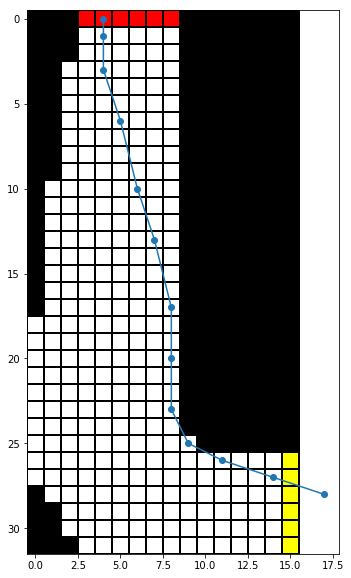

In [77]:
rt.draw_episode(S, A, R)

In [111]:
Q_joakim = np.load(os.path.join(os.getcwd(), 'Q_matrix_Joakim.csv.npy'))

In [98]:
Q_troels = np.load(os.path.join(os.getcwd(), 'Q_matrix_Troels.csv.npy'))

In [57]:
class OffPolicyMonteCarloAgent:
    def __init__(self, track, gamma=0.25, n_episodes=100000, eps=0.9):
        self.track = track
        self.gamma = gamma
        self.n_episodes = n_episodes
        self.eps = eps

        # Initialize Q values and C values
        y_range = track.track.shape[0]
        x_range = track.track.shape[1]
        yvel_range = track.max_vel - track.min_vel + 1
        xvel_range = track.max_vel - track.min_vel + 1
        yacc_range = 3  # -1, 0, +1
        xacc_range = 3  # -1, 0, +1

        # Initialize state-action values
        self.Q = np.zeros((y_range, x_range, yvel_range,
                           xvel_range, yacc_range, xacc_range))
        
        self.C = np.zeros_like(self.Q)

        # Initial Policy
        # For each state: assign equal probability of selecting each valid action from the state
        self.pi = np.zeros((y_range, x_range, yvel_range, xvel_range), dtype=object)
        for y_coord in range(self.Q.shape[0]):
            for x_coord in range(self.Q.shape[1]):
                for y_vel in range(track.min_vel, track.max_vel + 1):
                    for x_vel in range(track.min_vel, track.max_vel + 1):
                        valid_actions = self.track.possible_actions(
                            (y_coord, x_coord, y_vel, x_vel))
                        self.pi[y_coord, x_coord, y_vel, x_vel] = np.random.choice(valid_actions)
                        
    def behavior_policy(self, state):
        if random.random() <= self.eps:
            possible_actions = self.track.possible_actions(state)
            return random.choice(possible_actions)
        return self.pi[tuple(state)]
                        
    def policy_iteration(self):
        policy_stable = False
        it = 0
        while True:
            if self.n_episodes is not None and it > self.n_episodes:
                break
            elif self.n_episodes is None and policy_stable:
                break
            
            print('Iteration {}'.format(it))                            

            # (a) Generate an episode using pi
            S, A, R = self.generate_episode(b)

            G = 0
            W = 1
            for dt in range(len(S)-2, 0, -1):
                St, At, Rt = S[dt], A[dt], R[dt]
                state_action_key = tuple(St.tolist() + list(At))

                G = self.gamma * G + R[dt]
                self.C[state_action_key] = self.C[state_action_key] + W
                self.Q[state_action_key] = self.Q[state_action_key] + W/self.C[state_action_key] * (G - self.Q[state_action_key])
                self.pi[tuple(St)] = self.greedy_action(St)

                if At is not self.pi[tuple(St)]:
                    break

                W = W/b[state_action_key]
        